Heston:
$d S(t)=r S(t) d t+\sqrt{\nu(t)} S(t) d W_{1}(t)$
$d \nu(t)=\varkappa(\vartheta-\nu(t)) d t+\xi \sqrt{\nu(t)} d W_{2}(t)$
$\left\langle d W_{1}, d W_{2}\right\rangle=\rho d t$
$S(0)=S_{0}$
$\nu(0)=\nu_{0}$
Heston 多运用在股票类衍生品定价中。
其中, $\nu(t)$ 为基于 $t$ 的波动率模型, 并且是一个均值回归的过程, 这个可以通过$d\nu(t)$看出来。
其中$\varkappa$ 为均值回归的速度, $\vartheta$ 是一个长期方差, 也就是整个 $d \nu(t)$ 都是围绕长期方差来均值回归
$\xi$ 是就是波动率的波动率。 $\vartheta$ 与 $\xi$ 均为常数。
两个维纳过程 $d W_{1}(t), d W_{2}(t)$ 是两个相关的随机过程,相关系数为$\rho$,这里会用到Cholesky分解,具体方法与内容可以参考：https://zhuanlan.zhihu.com/p/132341192

In [23]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
r = 0.00
S0 = 1.0
V0 = 0.2**2
T = 1.
kappa = 1.
theta = V0
xi = 0.5
rho = -0.7
npath = 10000
nstep = 1000
dt = T/nstep
C = [[1.0, rho],[rho, 1.0]]
L = np.linalg.cholesky(C)
S = S0*np.ones((nstep+1,npath))
V = V0*np.ones((nstep+1,npath))

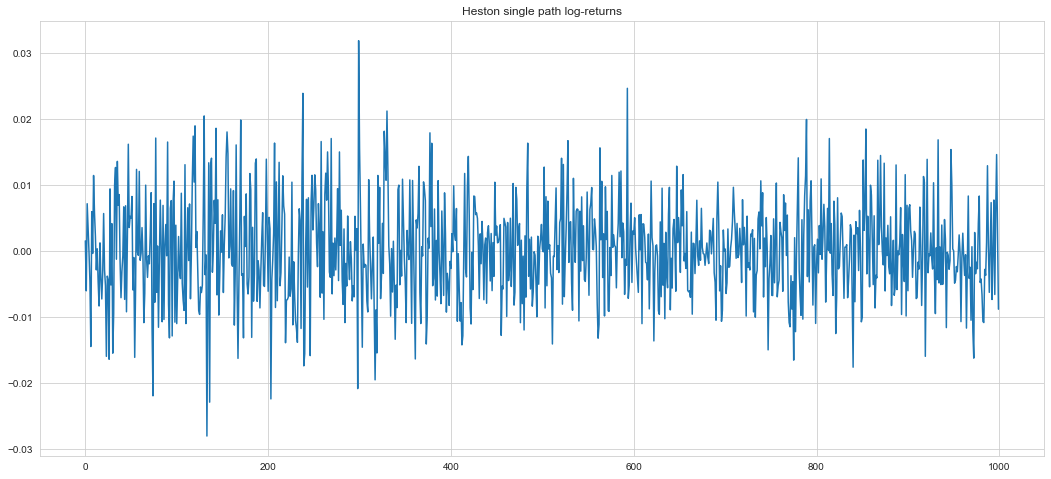

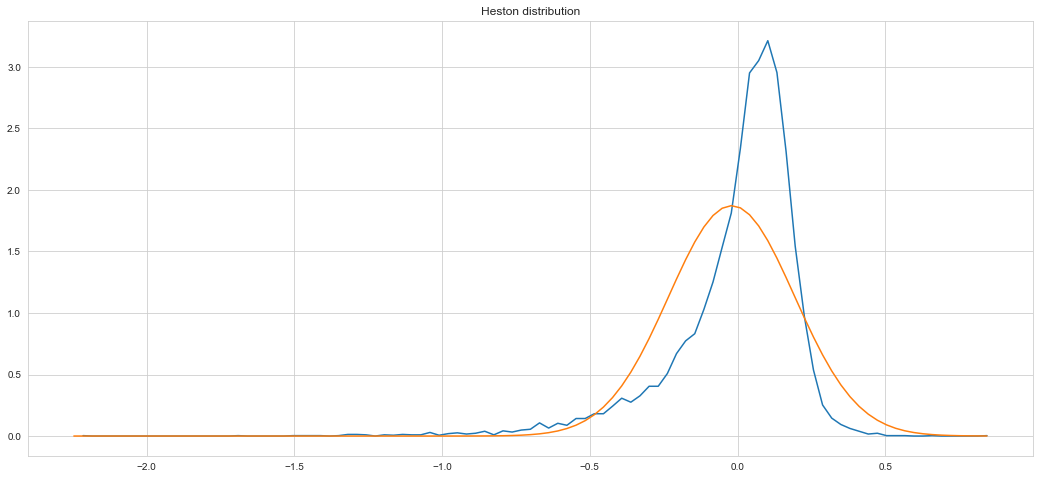

In [27]:
for i in range(0,nstep):
    ZH = np.random.normal(size=(2,npath//2)) # 生成了两行标正随机数，代表dW1和dW2
    z = np.c_[ZH,-ZH] # 用到 antithetic sampling variance reduction，将ZH的方差减小（虽然不知道为什么要这么做。。。
    Z = L @ z
    '''
    L为[1  ,0
       -0.7,0.714]，所以这两个矩阵乘积Z的第一行就是z的第一行,不变。由于L是两个dW的相关性矩阵的CH分解，Z的第二行就不会跟z一样了。
    我的理解是,这一步通过CH分解，使得两不相关，或者说相关系数随机的正态分布随机数（ZH的两行数），他们之间的相关性变为rho
    '''
    dS = r*S[i,:]*dt + np.sqrt(V[i,:]) * S[i,:] * np.sqrt(dt) * Z[0,:]
    S[i+1,:] = S[i,:] + dS
    dV = kappa*(theta - V[i,:])*dt + xi * np.sqrt(V[i,:]) * np.sqrt(dt) * Z[1,:]
    V[i+1,:] = np.maximum(V[i,:] + dV,0)  # to avoid negative vols

# 画出Heston模型生成的其中一条路径的log return
fig = plt.figure(figsize=(18,8))
plt.plot(np.diff(np.log(S[:,0])))
plt.title('Heston single path log-returns')
plt.show()

lnST = np.log(S[-1,:]) # 最终生成的所有价格的对数
y, x = np.histogram(lnST,100) # np.histogram：会返回两个数组，第一个数组表示的是，lnST中的元素落在对应第二个数组中的元素的区间内的个数
mH = np.mean(lnST)
sH = np.std(lnST)
yn = scipy.stats.norm.pdf(x,loc=mH,scale=sH)

fig = plt.figure(figsize=(18,8))
plt.plot(x[1:],y/npath/(x[1]-x[0]),label='distibution of heston log return'); # y是出现的次数，除以总共生成的数量npath后就是频率（概率）了，但为什么还要除以(x[1]-x[0])呢？
#(x[n]-x[n-1])是一个常数，说明np.histogram是把整个区间均分的
plt.plot(x,yn,label = 'norm distribution');
plt.title('Heston distribution');
plt.show()

SARB 模型多用于利率衍生品 (Interest Rate Derivatives) 的定价，他的 SDE 为：
$d F(t)=\sigma(t) F(t)^{\beta} d W_{1}(t)$
$d \sigma(t)=\alpha \sigma(t) d W_{2}(t)$
$\left\langle d W_{1}, d W_{2}\right\rangle=\rho d t$
$F(0)=F_{0}$
$\sigma(0)=\sigma_{0}$
其中 $F$ 为远期利率, $\alpha$ 为 波动率的波动率, $\beta$ 则是对于远期利率分布的一个 Skewness Power (实在不知道怎么翻译...), 同样两个维纳过程 $d W_{1}(t), d W_{2}(t)$ 是两个相关的随机过程, 相关系数 为 $\rho$ 。那么还是模拟一下这两个过程。假设:
$$
\begin{aligned}
&F_{0}=1 \\
&r=0 \\
&\sigma_{0}=0.2 \\
&\beta=1 \\
&\rho=-0.7 \\
&\alpha=0.5
\end{aligned}
$$

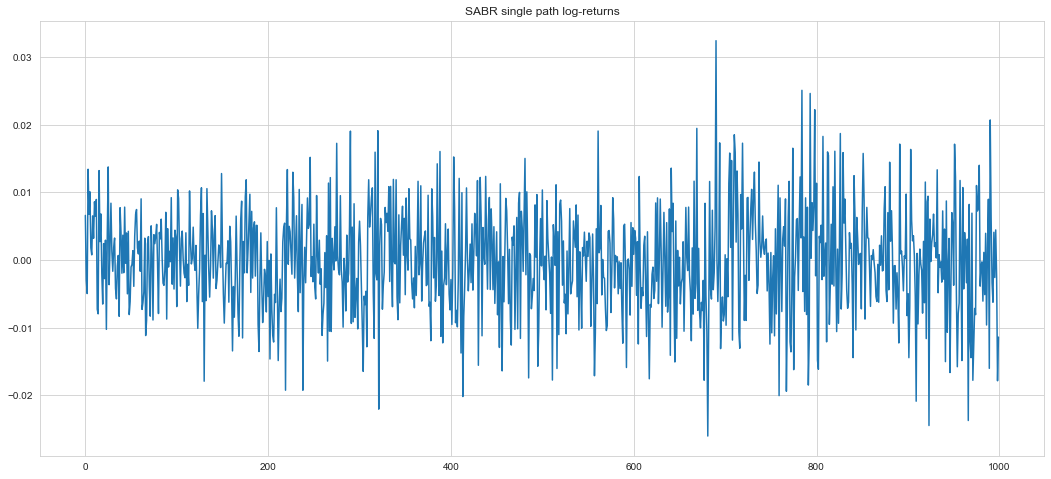

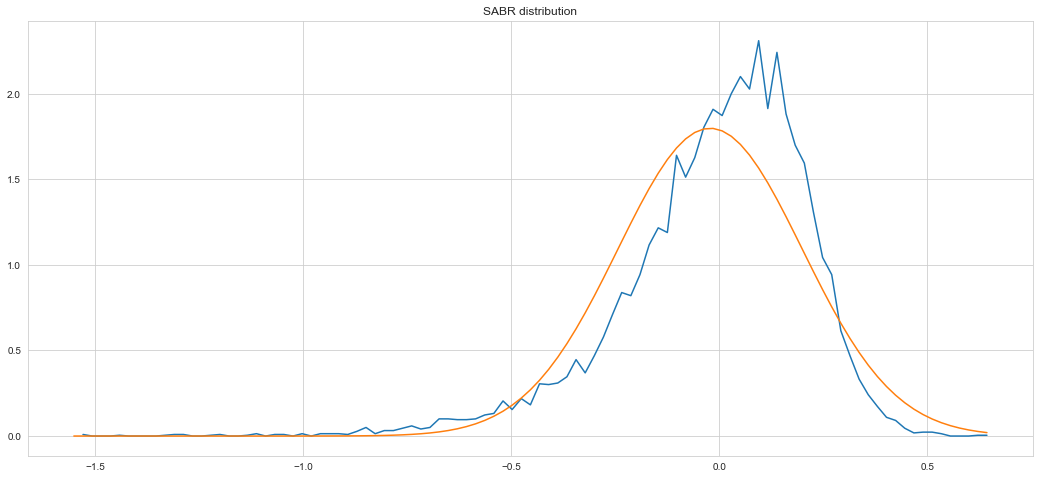

In [26]:
r = 0.00
F0 = 1.0
A0 = 0.2
T = 1.
S0 = F0*np.exp(-r*T)
beta = 1
rho = -0.7
alpha = 0.5
npath = 10000
nstep = 1000
dt = T/nstep
CH = [[1.0, rho],[rho, 1]]
L = np.linalg.cholesky(CH)
F = F0*np.ones((nstep+1,npath))
A = A0*np.ones((nstep+1,npath))
for i in range(0,nstep):
    ZH = np.random.normal(size=(2,npath//2))
    z = np.c_[ZH,-ZH] # antithetic sampling
    Z = L @ z
    dF = A[i,:]* np.power(F[i,:],beta) * np.sqrt(dt) * Z[0,:]
    F[i+1,:] = F[i,:] + dF
    dA = alpha * A[i,:] * np.sqrt(dt) * Z[1,:]
    A[i+1,:] = np.maximum(A[i,:] + dA,0)

fig = plt.figure(figsize=(18,8))
plt.plot(np.diff(np.log(F[:,0])))
plt.title('SABR single path log-returns')
plt.show()

lnFT = np.log(F[-1,:])
y, x = np.histogram(lnFT,100)
mS = np.mean(lnFT)
sS = np.std(lnFT)
yn = scipy.stats.norm.pdf(x,loc=mS,scale=sS)

fig = plt.figure(figsize=(18,8))
plt.plot(x[1:],y/npath/(x[1]-x[0]))
plt.plot(x,yn)
plt.title('SABR distribution')
plt.show()